# Predict media from taxa

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
import umap

import os
DATA_DIR = "~/Desktop/code/data/"

In [2]:
TARGET_VAR = "media_id"

RANDOM_SEED = 666

# UMAP parameters
UMAP_METRIC = "euclidean"
UMAP_SEED = 42

In [3]:
data_df = pd.read_csv(os.path.join(DATA_DIR, "media2ec-explode.csv"), low_memory=False)
data_df = data_df.dropna(subset='component_id', how='any')
data_df['component_id'] = data_df['component_id'].astype(int)

In [4]:
data_df = data_df[["taxon_id", "media_id", "component_id"]]\
    .value_counts()\
    .reset_index()

data_df = data_df.pivot(
    index=["taxon_id", "media_id"],
    columns="component_id",
    values="count"
)
data_df = data_df.fillna(0.0).reset_index()
data_df

component_id,taxon_id,media_id,4,18,33,37,46,47,56,60,...,337,430,497,498,506,616,688,754,1353,1359
0,100,J349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1003997,J1052,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100468,J13,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1005740,J940,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1005944,J346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3253,"[{'NCBI tax id': 990998, 'Matching level': 'st...",514f,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3254,"[{'NCBI tax id': 997349, 'Matching level': 'st...",J14,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3255,"[{'NCBI tax id': 997353, 'Matching level': 'st...",J14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
3256,"[{'NCBI tax id': 999415, 'Matching level': 'st...",J84,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model

### Strategy for splitting

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_df.drop(["taxon_id", "media_id"], axis=1),
    data_df[TARGET_VAR],
    test_size=0.3,
    random_state=RANDOM_SEED
)

### Dimensionality reduction

In [6]:
reducer = umap.UMAP(
    metric=UMAP_METRIC,
    n_components=4,
    n_epochs=5000,
    random_state=UMAP_SEED,
    n_jobs=1
)

reduced_df = reducer.fit_transform(X_train)
reduced_df = pd.DataFrame(
    reduced_df,
    columns=[f"Component {i+1}" for i in range(reduced_df.shape[1])]
)
reduced_df.head()

,Component 1,Component 2,Component 3,Component 4
0,37.597717,9.514389,8.097389,-2.289544
1,1.520269,-7.637766,-6.705919,-3.775471
2,-5.642041,48.795933,0.771163,-48.059223
3,-7.731888,44.960350,2.985538,-47.923508
4,0.928959,-8.252604,-7.087095,-3.461657


### Clustering

In [7]:
# TODO: add silhouette score
# NOTE: using KMeans since the other classes do not provide a predict method
cluster = KMeans(
    n_clusters=4,
    random_state=RANDOM_SEED
)
reduced_df["Cluster"] = cluster.fit_predict(reduced_df.values)
reduced_df["Cluster"] = reduced_df["Cluster"].astype(str)

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


In [8]:
# Add ID columns
reduced_df[["taxon_id", "media_id"]] = \
    data_df.loc[X_train.index, ["taxon_id", "media_id"]].values

reduced_df.head()

,Component 1,Component 2,Component 3,Component 4,Cluster,taxon_id,media_id
0,37.597717,9.514389,8.097389,-2.289544,1,"[{'NCBI tax id': 1236535, 'Matching level': 's...",J119
1,1.520269,-7.637766,-6.705919,-3.775471,1,161920,J43
2,-5.642041,48.795933,0.771163,-48.059223,2,"[{'NCBI tax id': 100225, 'Matching level': 'sp...",J218
3,-7.731888,44.960350,2.985538,-47.923508,2,1481914,J118
4,0.928959,-8.252604,-7.087095,-3.461657,1,310297,J14


In [16]:
reduced_df.to_csv(os.path.join(DATA_DIR, "comp-model.csv"), index=False)

#### Visualise the results

In [9]:
fig = px.scatter_3d(
    data_frame=reduced_df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color="Component 4",
    hover_data=[
        "taxon_id",
        "media_id"
    ],
    template="plotly_white"
)
fig.show()

In [10]:
fig = px.scatter_3d(
    data_frame=reduced_df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color="Cluster",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    hover_data=[
        "taxon_id",
        "media_id"
    ],
    template="plotly_white"
)
fig.show()

#### Create new column from clusters

In [11]:
y_train = cluster.predict(reducer.transform(X_train))
y_test = cluster.predict(reducer.transform(X_test))

y_train

array([1, 1, 2, ..., 1, 1, 2])

### Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=666)

### Performance

#### Feature importances

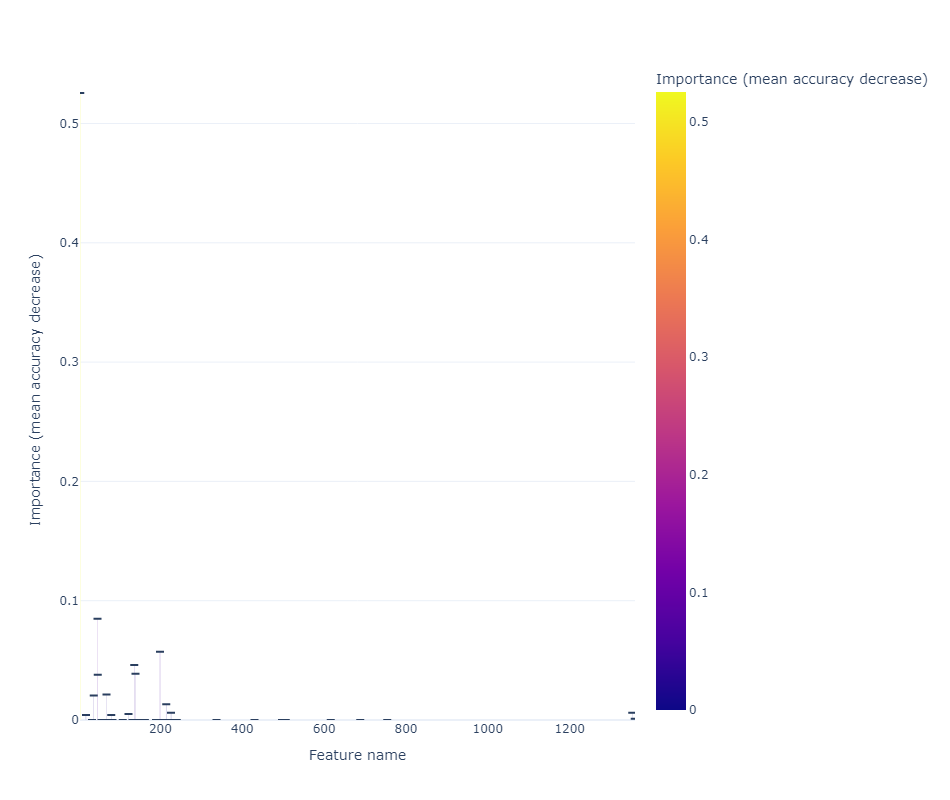

In [13]:
from sklearn.inspection import permutation_importance

result_importances = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=1,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

feat_importances = pd.DataFrame({
    "Feature name": X_train.columns,
    "Importance (mean accuracy decrease)": result_importances.importances_mean,
    "Importance (std)": result_importances.importances_std
})

# Sort them by mean
feat_importances = feat_importances\
    .sort_values("Importance (mean accuracy decrease)")

fig = px.bar(
    data_frame=feat_importances,
    x="Feature name",
    y="Importance (mean accuracy decrease)",
    error_y="Importance (std)",
    color="Importance (mean accuracy decrease)",
    width=950,
    height=800,
    template="plotly_white"
)
fig.show("png")

#### Metrics

In [14]:
y_pred = model.predict(X_test)

report = classification_report(
    y_true=y_test,
    y_pred=y_pred,
    zero_division="warn"
)

print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       0.99      1.00      1.00       540
           2       1.00      1.00      1.00       227
           3       1.00      0.97      0.99       115

    accuracy                           1.00       978
   macro avg       1.00      0.99      1.00       978
weighted avg       1.00      1.00      1.00       978



In [15]:
from sklearn import metrics

# TODO: get PR-REC AUC score
# TODO: plot both ROC and PR-REC curves
roc_score = metrics.roc_auc_score(
    y_true=y_test,
    y_score=model.predict_proba(X_test),
    average="weighted",
    multi_class="ovo"
)

print("ROC AUC score:", roc_score)

ROC AUC score: 0.9999748355391341
